In [26]:
#ABALONE_PREDICTION
import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

##UTILITY FUNCTIONS

In [27]:
import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict


def split_data(X, y, test_size=0.1, seed=None):
    # shuffle data
    np.random.seed(seed)
    perm = np.random.permutation(X.index)
    X = X.loc[perm]
    y = y.loc[perm]
    
    # split into training and test sets
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        if test_size <= 0 or test_size >= 1:
            raise ValueError("The test size should fall in the range (0,1)")
        n_train = n_samples - round(test_size*n_samples)
    elif isinstance(test_size, int):
        n_train = n_samples - test_size
    else:
        raise ValueError("Improper type \'%s\' for test_size" % type(test_size))

    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, X_test, y_train, y_test

def encode_one_hot(data): # note: pd.get_dummies(df) does the same
    # https://www.kite.com/python/answers/how-to-do-one-hot-encoding-with-numpy-in-python
    one_hot = np.zeros((data.size, data.max()+1))
    rows = np.arange(data.size)
    one_hot[rows, data] = 1
    return one_hot


def confusion_matrix(y_actual, y_pred):
    """ Returns a confusion matrix where the rows are the actual classes, and the columns are the predicted classes"""
    if y_actual.shape != y_pred.shape:
        raise ValueError ("input arrays must have the same shape, {}!={}".format(y_actual.shape, y_pred.shape))
    n = max(max(y_actual), max(y_pred)) + 1
    C = np.zeros((n, n), dtype=int)
    for label_actual in range(n):
        idxs_true = (y_actual == label_actual)
        for label_pred in range(n):
            C[label_actual, label_pred] = sum(y_pred[idxs_true] == label_pred)
    return C

def calc_f1_score(y_actual, y_pred) -> Tuple[float]:
    C = confusion_matrix(y_actual, y_pred)
    if C.shape[0] != 2:
        raise ValueError ("input arrays must only have binary values")
    recall    = C[1][1]/(C[1][0]+C[1][1]) #true positive/actual positive
    precision = C[1][1]/(C[0][1]+C[1][1]) #true positive/predicted positive
    if (recall == 0) or (precision == 0):
        f1 = 0
    else:
        f1 = 2 * recall*precision/(recall + precision) # = 2/((1/recall)+(1/precision))

    print("Recall: {:.4f}".format(recall))
    print("Precision: {:.4f}".format(precision))
    print("F1 Score: {:.4f}".format(f1))


In [28]:
import numpy as np
import pickle

class LogisticRegression:
    """Logistic regression model."""
    def __init__(self, learning_rate=0.01, num_iterations=10000, fit_intercept=True):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
    
    def add_intercept(self, X):
        """Add intercept to data."""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def sigmoid(self, z):
        """Compute the sigmoid function of the input."""
        return 1 / (1 + np.exp(-z))

    def loss(self, y, h):
        """Compute the binary cross-entropy loss."""
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        """Fit logistic regression model to data."""
        if self.fit_intercept:
            X = self.add_intercept(X)

        # Initialize model parameters
        self.theta = np.zeros(X.shape[1])

        # Perform gradient descent
        for i in range(self.num_iterations):
            # Compute predicted probabilities
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)

            # Compute gradients
            gradient = np.dot(X.T, (h - y)) / y.size

            # Update model parameters
            self.theta -= self.learning_rate * gradient

            # Print loss every 1000 iterations
            if i % 1000 == 0:
                z = np.dot(X, self.theta)
                h = self.sigmoid(z)
                loss = self.loss(y, h)
                print(f'Iteration {i}, Loss: {loss}')

    def predict(self, X):
        """Make predictions using logistic regression model."""
        if self.fit_intercept:
            X = self.add_intercept(X)

        # Compute predicted probabilities
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)

        # Return binary predictions
        return (h > 0.5).astype(int)

    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def save(self, filename):
        """Save trained model parameters to a pickle file."""
        with open(filename, 'wb') as f:
            pickle.dump(self.theta, f)

    @classmethod
    def load(cls, filename):
        """Load trained model parameters from a pickle file."""
        model = cls()
        with open(filename, 'rb') as f:
            model.theta = pickle.load(f)
        return model


#Problem Definition

Predict the age of abalone based on the attributes.

Age is calculated by adding +1.5 to the number of rings.

In [29]:
col=['sex','length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight','rings']
df=pd.read_csv('/content/abalone.data',sep=',',names=col)
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [30]:
df.shape

(4177, 9)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [32]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [33]:
df[df['height'] == 0]  #need to drop these rows. becasuse Height Can't be Zero

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [34]:
df.drop(index=[1257,3996], inplace = True)
df.shape

(4175, 9)

In [35]:
df.isnull().sum()

sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
rings             0
dtype: int64

In [36]:
# Add age column
df["age"] = df["rings"] + 1.5

# Drop rings column
df.drop("rings", axis=1, inplace=True)


Our initial task was to determine the age of the abalone  based on the number of rings. We know that age is determined by the number of rings + 1.5. Therefore, we need to create a new ["Age"] column in our data and drop the ["Rings"] column.

Boxen Plot: Age Vs Sex

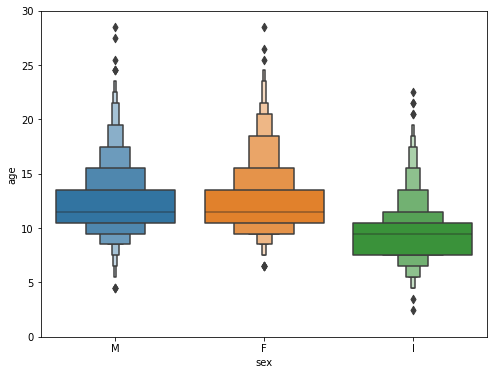

In [37]:
#categorical features
temp = pd.concat([df['age'], df['sex']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxenplot(x='sex', y="age", data=df)
fig.axis(ymin=0, ymax=30);



There is no difference in age of rings for male and female (8-19). But in infants, it lies between (5-10)

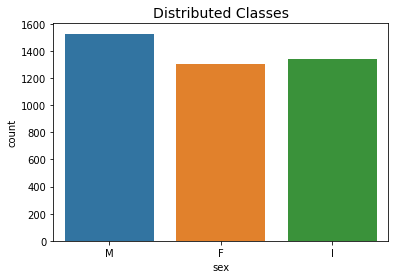

In [38]:
sns.countplot(x='sex', data=df)
plt.title('Distributed Classes', fontsize=14)
plt.show()

array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'diameter'}>,
        <Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'whole_weight'}>],
       [<Axes: title={'center': 'shucked_weight'}>,
        <Axes: title={'center': 'viscera_weight'}>,
        <Axes: title={'center': 'shell_weight'}>,
        <Axes: title={'center': 'age'}>]], dtype=object)

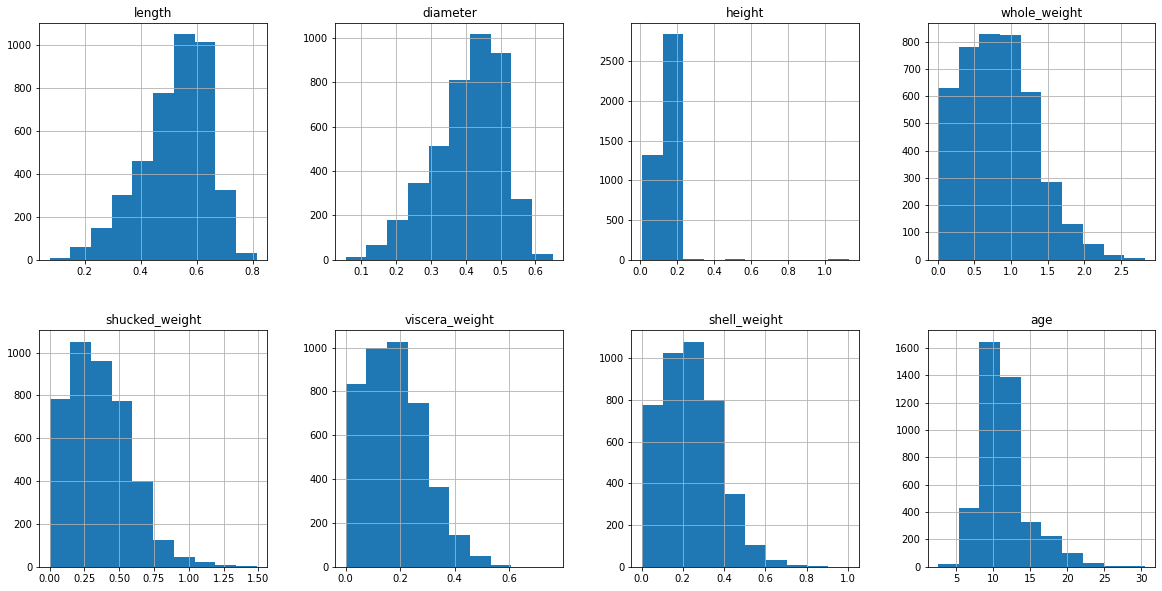

In [39]:
df.hist(figsize = (20,10), layout = (2,4))

Skewness of the height is too high. (need to normalise later...)
Need to check skewness for all varibles

Skewness of the Variables

In [40]:
df.skew().sort_values(ascending = False)

<ipython-input-40-8c896329b03f>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew().sort_values(ascending = False)


height            3.166364
age               1.113754
shucked_weight    0.718735
shell_weight      0.621081
viscera_weight    0.591455
whole_weight      0.530549
diameter         -0.610182
length           -0.640993
dtype: float64

Skewness is close to 0 for Normal distribution curve.
Height has the highest skewness of 3.17

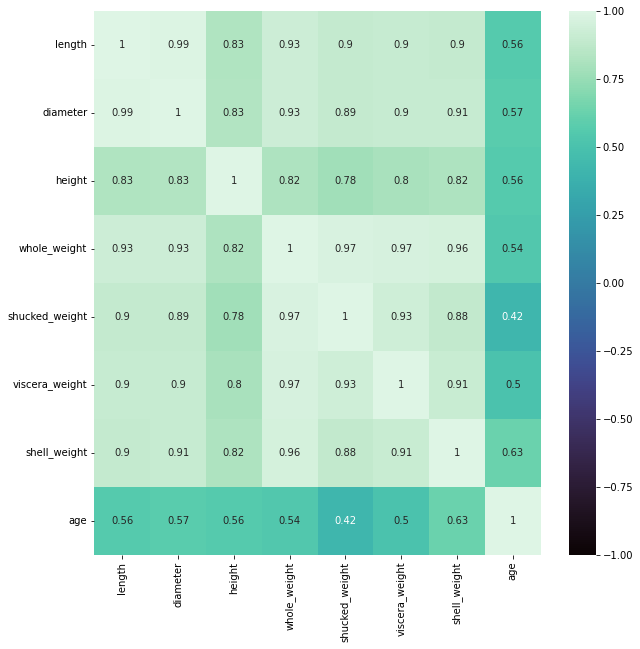

In [41]:
corr = df.corr()
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr, vmin = -1, center = 0, annot = True, cmap = 'mako')



No Negative correlation found
High coorelation between Length & Diameter
High corelation between shucked weight, viscera weight Vs Whole_weight & Shell weight vs Whole_weight

In [42]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
columns_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)] #highly correlated variables to be removed.

print("Columns to drop:\n", columns_to_drop)

Columns to drop:
 ['diameter', 'shucked_weight', 'viscera_weight', 'shell_weight']


<ipython-input-42-b5b5958f62a0>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))


In [43]:
df.drop(columns_to_drop, axis=1, inplace = True)

In [44]:
df.head()

,sex,length,height,whole_weight,age
0,M,0.455,0.095,0.5140,16.5
1,M,0.350,0.090,0.2255,8.5
2,F,0.530,0.135,0.6770,10.5
3,M,0.440,0.125,0.5160,11.5
4,I,0.330,0.080,0.2050,8.5


In [45]:
#calculating VIF
def vif_arr(df1):
    vif = pd.DataFrame()
    df1 = sma.add_constant(df1)
    vif["Features"] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    return(vif)

In [46]:
temp = df.drop('sex', axis = 1) #i.e. categorical
vif_arr(temp).sort_values(by = 'Features', ascending = False)

,Features,VIF
3,whole_weight,7.425114
1,length,7.833655
2,height,3.532659
0,const,62.359271
4,age,1.515261


Whole weight and length have slighter higher VIF. We will consider this as of now.

Text(0.5, 1.0, 'height vs sex')

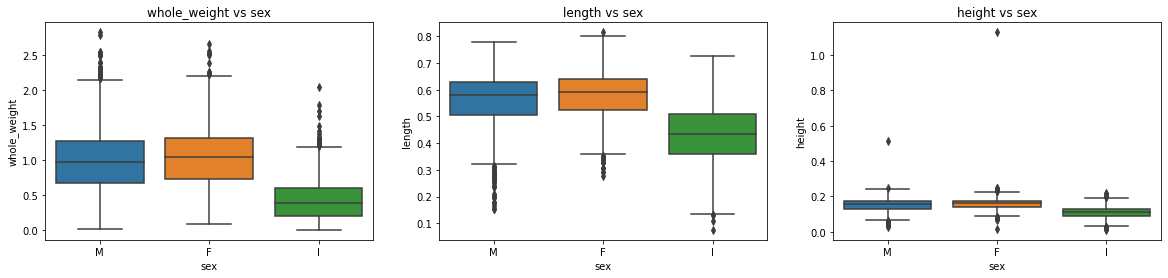

In [47]:
f, axes = plt.subplots(ncols = 3, figsize = (20,4))

sns.boxplot(x = 'sex', y = 'whole_weight', data = df, ax = axes[0])
axes[0].set_title('whole_weight vs sex')

sns.boxplot(x = 'sex', y = 'length', data = df, ax = axes[1])
axes[1].set_title('length vs sex')

sns.boxplot(x = 'sex', y = 'height', data = df, ax = axes[2])
axes[2].set_title('height vs sex')

Normalise Height

By doing Square root transofrmation

In [48]:
df['height'] = np.sqrt(df['height'])

In [49]:
#checking skewness again
df.skew().sort_values(ascending = False)

<ipython-input-49-0c526a3b9e51>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew().sort_values(ascending = False)


age             1.113754
whole_weight    0.530549
height         -0.176012
length         -0.640993
dtype: float64

All independent varibles values are close to zero. So, they are now close to gaussian distribution. 

array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'whole_weight'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

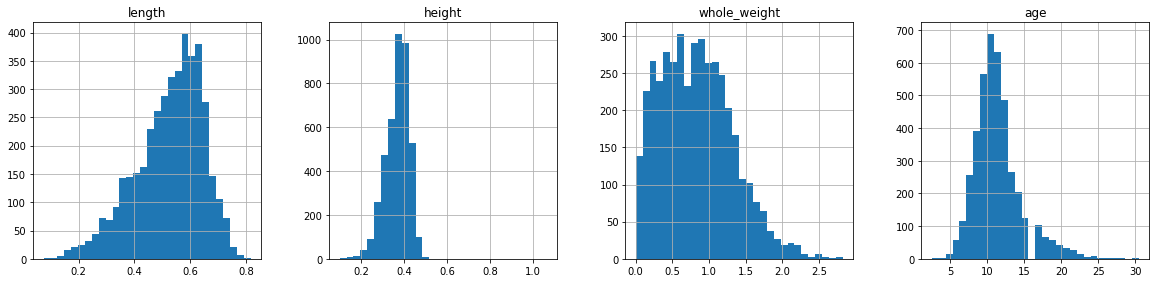

In [50]:
#Distribution of the Numerical Features
df.hist(figsize = (20,10), layout = (2,4), bins = 30)

As we can see, previously Height was highly skewed. But now, its normally distributed
All skewed data values are close to 0.

In [51]:
df.head()

,sex,length,height,whole_weight,age
0,M,0.455,0.308221,0.5140,16.5
1,M,0.350,0.300000,0.2255,8.5
2,F,0.530,0.367423,0.6770,10.5
3,M,0.440,0.353553,0.5160,11.5
4,I,0.330,0.282843,0.2050,8.5


In [52]:
Age = []
for i in df["whole_weight"]:
    if i < 0.6:
        Age.append(1)
    elif i > 0.6 and i < 1.0 :
        Age.append(2)
    else:
        Age.append(3)
df["age"] = Age
#df_1.drop("age" , axis =1,inplace=True)
df.head()

,sex,length,height,whole_weight,age
0,M,0.455,0.308221,0.5140,1
1,M,0.350,0.300000,0.2255,1
2,F,0.530,0.367423,0.6770,2
3,M,0.440,0.353553,0.5160,1
4,I,0.330,0.282843,0.2050,1


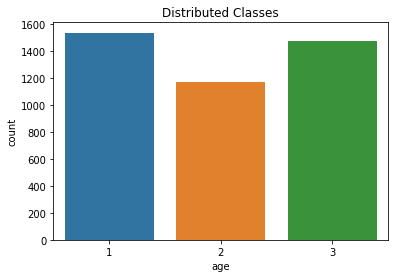

In [57]:
sns.countplot(x='age', data=df)
plt.title('Distributed Classes')
plt.show()

In [58]:
new_df = pd.get_dummies(df, columns = ['sex'], prefix_sep='_', drop_first = True)
new_df['age'].value_counts()

1    1534
3    1473
2    1168
Name: age, dtype: int64

In [59]:
#VIF For All Independent Features CombinedVIF For All Independent Features Combined

#NEW VIF
vif_arr(new_df).sort_values(by = 'Features', ascending = False)

,Features,VIF
3,whole_weight,9.799019
6,sex_M,1.384868
5,sex_I,1.983488
1,length,9.680103
2,height,4.979747
0,const,128.016288
4,age,5.326806


In [60]:
new_df['length'] = np.sqrt(new_df['length'])
vif_arr(new_df).sort_values(by = 'Features', ascending = False)

,Features,VIF
3,whole_weight,8.556129
6,sex_M,1.384512
5,sex_I,1.984036
1,length,7.495609
2,height,5.302027
0,const,249.609951
4,age,5.264169


In [61]:
X = new_df.drop('age', axis = 1)
y = new_df['age']


In [62]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.3)

In [63]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((2923, 5), (2923,), (1252, 5), (1252,))

In [64]:
# Fit logistic regression model to data
lr = LogisticRegression(num_iterations=1000, learning_rate=0.1, fit_intercept=True)


# train the model on the training data
lr.fit(X_train, y_train)


# evaluate the performance of the model on the test data
acc_test = lr.score(X_test, y_test)
acc_train = lr.score(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

Iteration 0, Loss: 0.033059046010390294


In [65]:

print("Logistic Regression model")
print("train accuracy: %.2f%%" % (acc_train*100))
print("test accuracy:  %.2f%%" % (acc_test*100))
print(y_pred)

Logistic Regression model
train accuracy: 37.05%
test accuracy:  36.02%
[1 1 1 ... 1 1 1]


In [66]:
confusion_matrix(y_test,y_pred)

array([[  0,   0,   0,   0],
       [  0, 451,   0,   0],
       [  0, 348,   0,   0],
       [  0, 453,   0,   0]])

In [67]:
# Train a logistic regression model and save its parameters to a pickle file
model = LogisticRegression()
model.fit(X_train, y_train)
with open('model.pkl', 'wb') as f:
    pickle.dump(model.theta, f)

# Load the trained model from the pickle file
loaded_model = LogisticRegression.load('model.pkl')




Iteration 0, Loss: 0.6251251216400912


<ipython-input-28-9110bc555494>:22: RuntimeWarning: divide by zero encountered in log
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()


Iteration 1000, Loss: -inf
Iteration 2000, Loss: -inf
Iteration 3000, Loss: -inf
Iteration 4000, Loss: -inf
Iteration 5000, Loss: -inf
Iteration 6000, Loss: -inf
Iteration 7000, Loss: -inf
Iteration 8000, Loss: -inf
Iteration 9000, Loss: -inf
